In [1]:
import Pkg;
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Code/ExperimentsPseudospectra.jl/notebook`


# Numerical oracle for the constants

In this section we do some numerical computations to narrow down the set of parameters. Later on, we will use self-validated numerical methods (Interval Arithmetic) to certify the 
numerical values we computed now.

In [2]:
using Plots

In [3]:
Pkg.status()

Status `~/Code/ExperimentsPseudospectra.jl/notebook/Project.toml`
  [77e4f72b] BallArithmetic v0.1.1
⌅ [d1acc4aa] IntervalArithmetic v0.20.9
  [91a5bcdd] Plots v1.40.8
  [6103b61f] RigorousInvariantMeasures v0.2.3
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


We fix the truncation size for the Galerkin approximation.

In [4]:
K = 512
N = 2*K+1

1025

We start by defining the Blashke product 
$$
B_{\mu}(z) = \frac{z (\mu - z)} {1 - \bar{\mu} z},
$$
with $\mu = \frac{17\sqrt{2}}{32} e^{i \pi/8}$.

In [5]:
r = sqrt(2)*17/32 
ϕ = π / 8

max_r = 10.0
μ = r * exp(im * ϕ)
B(z; μ=μ) = (z * (μ - z)) / (1 - μ' * z)

B (generic function with 1 method)

Let $A_{r} = \{z \mid e^{-2\pi r}\leq |z| \leq e^{2\pi r}\}$.

We are interested in finding $\eta$, $\rho$ such that the closure $A_{\rho}$ is contained in $B_{\mu}(A_{\eta})$.
We are interested in maximizing $\rho-\eta$, since it is the constant appearing in the main error term of our functional analytic treatment, i.e.:
$$
||Lf-L_Kf||_{\ell^1}\leq \left(1+2\frac{e^{-2 \pi |\rho-\alpha|}}{1-e^{-2 \pi |\rho-\alpha|}}\right)\left(e^{-2\pi K\alpha}+e^{-2\pi K(\alpha-\eta)}\right)||f||_{\infty, \alpha}.	
$$

For $\rho>1$ fix
$$
\alpha_o(\rho):=\min_{\theta \in [0,1]}|B(\rho e^{2\pi i \theta})|
$$
where $_0$ stays for outer and 
$$
OR(\rho) := \frac{1}{2\pi}\left(\log(\alpha_o(\rho))-\log(\rho)\right).
$$
We would like to maximize the function $LR$.

In [6]:
α_o(ρ) = minimum(abs.(B.([ρ * exp(im * 2 * π * θ) for θ in 0:0.001:1])))
function OR(ρ)   
    return (log(α_o(ρ))-log(ρ))/2π
end

OR (generic function with 1 method)

Similarly, we would like to treat the image inside the circle; for $\rho>1$ we define 
$$
\alpha_i(\rho) :=\min_{\theta \in [0,1]}\frac{1}{\left|B\left(\frac{e^{2\pi i \theta}}{\rho}\right)\right|}
$$
and 
$$
IR(\rho) := \frac{1}{2\pi}\left(\log(\alpha_i(\rho))-\log(\rho)\right).
$$


In [15]:
α_i(ρ) = minimum(1.0 ./abs.(B.([exp(im * 2 * π * θ) / ρ for θ in 0:0.001:1])))
    
function IR(ρ) 
    return (log(α_i(ρ))-log(ρ))/2*π
end 

IR (generic function with 1 method)

We define now 
$$
LR(\rho) = \min\{IR(\rho),OR(\rho)\}
$$
and maximise it.

In [16]:
LR(ρ) = min(IR(ρ), OR(ρ))

LR (generic function with 1 method)

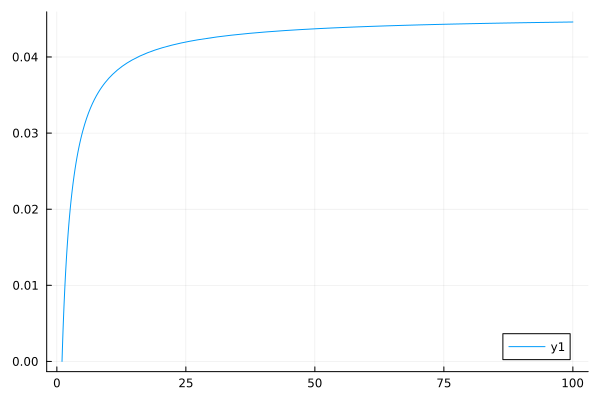

In [17]:
plot(LR, 1, 100)

In [34]:
η_rad = 1:0.1:10

bestrad, indexrad = findmax([LR(η) for η in η_rad])

η = η_rad[indexrad]

10.0

We move now to the strips

In [35]:
η_s = log(η)/2π
ρ_s = log(min(α_i(η), α_o(η)))/2π
η_s, ρ_s, ρ_s-η_s    

(0.3664677994397139, 0.40361956514781866, 0.037151765708104745)

We want to find now an $\alpha$ that minimizes the right hand side of
$$
||Lf-L_Kf||_{\ell^1}\leq \left(1+2\frac{e^{-2 \pi |\rho-\alpha|}}{1-e^{-2 \pi |\rho-\alpha|}}\right)\left(e^{-2\pi K\alpha}+e^{-2\pi K(\alpha-\eta)}\right)||f||_{\infty, \alpha}	
$$


In [36]:
function rhs(α, K; η, ρ)
    #Iα = interval(α)
    #Iη = interval(η)
    #Iρ = interval(ρ)
    Dρα = ρ-α
    Dαη = α-η
    coeff_1 = 1+2*(exp(-2*π*(Dρα)))/(1-(exp(-2*π*(Dρα))))
    coeff_2 = exp(-2*π*K*α)+exp(-2*π*K*(Dαη))
    return coeff_1*coeff_2
end

rhs (generic function with 1 method)

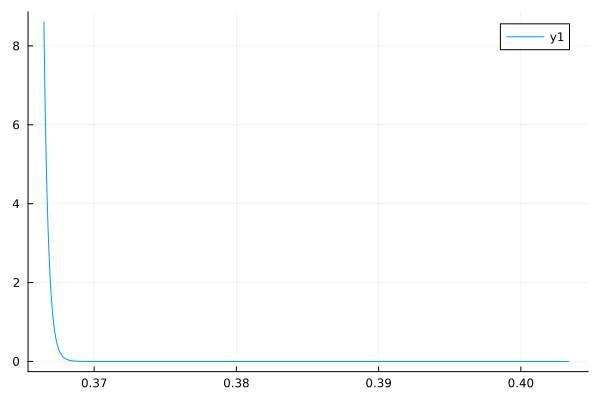

In [37]:
plot(α -> rhs(α, K; η = η_s, ρ = ρ_s), η_s, ρ_s)

In [38]:
α_arr = LinRange(η_s, ρ_s, 10000)
val_min, idx = findmin(map(α -> rhs(α, K; η = η_s, ρ = ρ_s), α_arr))
α_s = α_arr[idx]
val_min, α_s

(3.4599649993307605e-49, 0.40330745910526633)

We compute now the right hand side, supposing $|\mu|>1/2$
$$
||f||_{\infty, \alpha} \leq \left(\frac{1}{|\mu|}\right)^{\frac{\alpha}{\alpha-\eta}} \left( 1+2\frac{e^{-2 \pi |\rho-\alpha|}}{1-e^{-2 \pi |\rho-\alpha|}}\right)^{\frac{\alpha}{\alpha-\eta}} ||f||_{\ell^1}.
$$


In [39]:
function weak_strong(μ; η, α, ρ)
    s = α/(α-η)
    coeff_1 = (1/abs(μ))^s
    coeff_2 = 1+2*(exp(-2*π*(ρ-α)))/(1-(exp(-2*π*(ρ-α))))^s
    return coeff_1*coeff_2
end

weak_strong (generic function with 1 method)

In [40]:
bws = weak_strong(0.5; η = η_s, α = α_s, ρ = ρ_s)

1.7432099433662793e33

Clearly, the number above is ugly, but the fact that the projection error is small balances out.

In [41]:
(bws*val_min)*sqrt(N)

1.931004708343623e-14

# Certifying the constants

For the specific values of $\alpha$, $\rho$ and $\eta$ computed above, we will certify the value of the constants.

In [42]:
using IntervalArithmetic

In [ ]:
r = sqrt(interval(2))*17/32 
ϕ = interval(π) / 8

max_r = 10.0
μ = r * exp(im * ϕ)
IB(z; μ=μ) = (z * (μ - z)) / (1 - μ' * z)

B (generic function with 1 method)

In [ ]:
N = 1048576
Iα_o(ρ) = minimum(abs.(IB.([ρ * exp(im * 2 * interval(π) * interval(i, i+1)/N) for i in 0:N-1])))

α_o (generic function with 1 method)

In [ ]:
Iα_i(ρ) = minimum(1.0 ./abs.(IB.([exp(im * 2 * interval(π) * interval(i, i+1)/N) / ρ for i in 0:N-1])))

IR (generic function with 1 method)

In [ ]:
Iα_o(ρ_s), Iα_i(ρ_s)

([0.201403, 0.201408], [0.201401, 0.20141])

In [79]:
using RigorousInvariantMeasures, BallArithmetic

In [80]:

FourierBasis = RigorousInvariantMeasures.FourierAdjoint(K, 65536)

FFT on 65536 points restricted to highest frequency 512

In [81]:
S(x) = 0.5 + atan((sin(2 * pi * x) - r * sin(ϕ)) / (cos(2 * pi * x) - r * cos(ϕ))) / pi

S (generic function with 1 method)

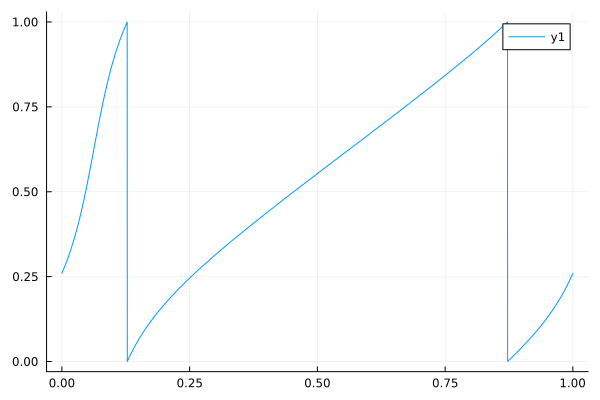

In [82]:
plot(S, 0, 1)

In [83]:
savefig("Blashke.png")

"/home/isaia/Dropbox/Lavoro/Collaborators/Blumenthal-Nisoli-Taylor-Crush/DraftPseudospectra/current/Julia_notebooks/Blashke.png"

In [84]:
P = DiscretizedOperator(FourierBasis, S)

NonIntegralPreservingDiscretizedOperator{Adjoint{Complex{Interval{Float64}}, Matrix{Complex{Interval{Float64}}}}, Vector{Float64}, Adjoint{Complex{Interval{Float64}}, Vector{Complex{Interval{Float64}}}}}(Complex{Interval{Float64}}[[0.999999, 1.00001] + [-2.36499e-14, 2.36499e-14]im [-2.36499e-14, 2.36499e-14] + [-2.36499e-14, 2.36499e-14]im … [-2.36499e-14, 2.36499e-14] + [-2.36499e-14, 2.36499e-14]im [-2.36499e-14, 2.36499e-14] + [-2.36499e-14, 2.36499e-14]im; [-2.52734e-14, 2.51401e-14] + [-2.51685e-14, 2.52449e-14]im [0.694111, 0.694112] + [-0.287511, -0.28751]im … [-2.51936e-14, 2.52198e-14] + [-2.51893e-14, 2.52242e-14]im [-2.52183e-14, 2.51952e-14] + [-2.51881e-14, 2.52253e-14]im; … ; [-2.67231e-14, 2.66614e-14] + [-2.66875e-14, 2.66971e-14]im [-2.6676e-14, 2.67086e-14] + [-2.66656e-14, 2.67189e-14]im … [0.399128, 0.399129] + [0.399128, 0.399129]im [-2.67454e-14, 2.66391e-14] + [-2.67371e-14, 2.66475e-14]im; [-2.52734e-14, 2.51401e-14] + [-2.52449e-14, 2.51685e-14]im [-2.52183e-1

In [85]:
import IntervalArithmetic
midI = IntervalArithmetic.mid
radI = IntervalArithmetic.radius

radius (generic function with 4 methods)

In [86]:
midP = midI.(real.(P.L)) + im * midI.(imag.(P.L))

1025×1025 Matrix{ComplexF64}:
          1.0+0.0im          …           0.0+0.0im
 -6.66496e-17+3.81792e-17im      -1.1549e-17+1.86067e-17im
 -3.08677e-17-4.79082e-18im      1.63007e-17-2.66466e-17im
 -7.57315e-17-3.89415e-17im     -4.31748e-17-3.71344e-17im
 -1.05844e-16+1.61218e-17im     -7.78535e-17-9.23976e-18im
 -5.76931e-17+3.91058e-17im  …  -3.16265e-17+1.64795e-17im
  -4.3188e-17-1.45419e-17im     -8.36798e-19-2.73783e-17im
 -8.23723e-17-4.02629e-17im      -5.9319e-17-4.39442e-17im
 -9.95247e-17+1.24498e-17im     -7.90027e-17+9.44092e-18im
 -5.33089e-17+3.46199e-17im      -2.4268e-17+1.94898e-17im
             ⋮               ⋱  
 -5.33089e-17-3.46199e-17im     -3.43889e-17-5.17265e-17im
 -9.95247e-17-1.24498e-17im     -8.37008e-17-2.68058e-17im
 -8.23723e-17+4.02629e-17im      -8.6234e-17+2.79269e-17im
  -4.3188e-17+1.45419e-17im     -2.41699e-17-4.65901e-18im
 -5.76931e-17-3.91058e-17im  …   -4.6237e-17-6.69562e-17im
 -1.05844e-16-1.61218e-17im     -9.82085e-17-2.61974e-17im
 

In [87]:
radP = sqrt.(radI.(real.(P.L))^2 + radI.(imag.(P.L))^2)

1025×1025 Matrix{Float64}:
 4.41975e-12  4.41975e-12  4.41975e-12  …  4.41975e-12  4.41975e-12
 4.5629e-12   4.5629e-12   4.5629e-12      4.5629e-12   4.5629e-12
 4.69543e-12  4.69543e-12  4.69543e-12     4.69543e-12  4.69543e-12
 4.82386e-12  4.82386e-12  4.82386e-12     4.82386e-12  4.82386e-12
 4.95014e-12  4.95014e-12  4.95014e-12     4.95014e-12  4.95014e-12
 5.05648e-12  5.05648e-12  5.05648e-12  …  5.05648e-12  5.05648e-12
 5.19125e-12  5.19125e-12  5.19125e-12     5.19125e-12  5.19125e-12
 5.31247e-12  5.31247e-12  5.31247e-12     5.31247e-12  5.31247e-12
 5.42379e-12  5.42379e-12  5.42379e-12     5.42379e-12  5.42379e-12
 5.52338e-12  5.52338e-12  5.52338e-12     5.52338e-12  5.52338e-12
 ⋮                                      ⋱               
 5.52338e-12  5.52338e-12  5.52338e-12     5.52338e-12  5.52338e-12
 5.42379e-12  5.42379e-12  5.42379e-12     5.42379e-12  5.42379e-12
 5.31247e-12  5.31247e-12  5.31247e-12     5.31247e-12  5.31247e-12
 5.19125e-12  5.19125e-12  5.1912

In [88]:
BallP = BallMatrix(midP, radP)

1025×1025 BallMatrix{Float64, ComplexF64, Ball{Float64, ComplexF64}, Matrix{ComplexF64}, Matrix{Float64}}:
                  1.0+0.0im ± 4.41975e-12  …                   0.0+0.0im ± 4.41975e-12
  -6.66496e-17+3.81792e-17im ± 4.5629e-12       -1.1549e-17+1.86067e-17im ± 4.5629e-12
 -3.08677e-17-4.79082e-18im ± 4.69543e-12      1.63007e-17-2.66466e-17im ± 4.69543e-12
 -7.57315e-17-3.89415e-17im ± 4.82386e-12     -4.31748e-17-3.71344e-17im ± 4.82386e-12
 -1.05844e-16+1.61218e-17im ± 4.95014e-12     -7.78535e-17-9.23976e-18im ± 4.95014e-12
 -5.76931e-17+3.91058e-17im ± 5.05648e-12  …  -3.16265e-17+1.64795e-17im ± 5.05648e-12
  -4.3188e-17-1.45419e-17im ± 5.19125e-12     -8.36798e-19-2.73783e-17im ± 5.19125e-12
 -8.23723e-17-4.02629e-17im ± 5.31247e-12      -5.9319e-17-4.39442e-17im ± 5.31247e-12
 -9.95247e-17+1.24498e-17im ± 5.42379e-12     -7.90027e-17+9.44092e-18im ± 5.42379e-12
 -5.33089e-17+3.46199e-17im ± 5.52338e-12      -2.4268e-17+1.94898e-17im ± 5.52338e-12
                       

In [89]:
using Pseudospectra

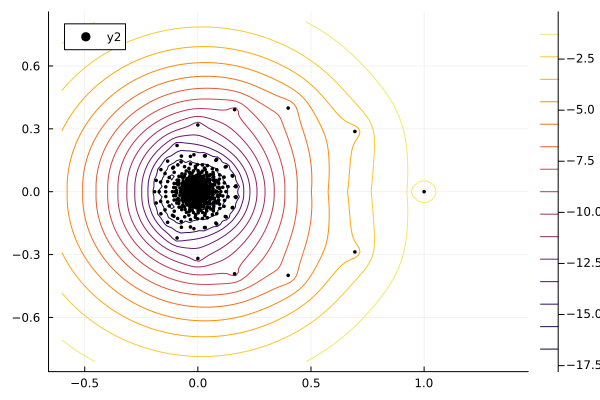

In [90]:
spectralportrait(midP)

In [91]:
savefig("PseudospectraGalerkinBlashke.png")

"/home/isaia/Dropbox/Lavoro/Collaborators/Blumenthal-Nisoli-Taylor-Crush/DraftPseudospectra/current/Julia_notebooks/PseudospectraGalerkinBlashke.png"

In [92]:
using LinearAlgebra
abs.(diag(schur(midP).T))

1025-element Vector{Float64}:
 0.7513009550106898
 0.751300955010684
 0.5644531250233265
 0.564453125024042
 0.4240741672174206
 0.4240741672769339
 0.3186085319892757
 0.3186084673000446
 0.2392158217087899
 0.2392166687611465
 ⋮
 2.8450808188099954e-15
 2.3905604358926875e-15
 2.4335223703674515e-15
 2.2148154817274752e-15
 1.699918565215941e-15
 1.9152349145962733e-15
 6.861686809829886e-16
 2.649402358090582e-16
 1.0

With this discretization size we are not going to separate 
things that are separated by less than $0.0025$.
By inspecting the eigenvalues of the Schur matrix, we see that it may be difficult to separate the eigenvalues with norm $0.522...$, that corresponde to a double eigenvalue.
Therefore we resolve to enclose a bigger circle than $0.5$.  

In [93]:
function certify_enclosure(enc, discr_error, weak_strong, errF, errT, norm_Z, norm_Z_inv)
    N = length(enc.points)

    r = Inf
    for i in 1:N
        abs_z = abs(Ball(enc.points[i], enc.radiuses[i]))
        r = min(r, BallArithmetic.sub_down(abs_z.c, abs_z.r))
    end
    δ = BallArithmetic.bound_resolvent(enc, errF, errT, norm_Z, norm_Z_inv)
    left_side = r #BallArithmetic.div_down(1.0, r) # @down
    right_side = BallArithmetic.mul_up(BallArithmetic.mul_up(weak_strong, discr_error), δ) #up
    @info left_side, right_side
    if left_side > right_side
        @info "The enclosure of ", enc.λ, "is certified"
        return true
    else
        return false
    end
end

certify_enclosure (generic function with 1 method)

In [94]:
A = BallP

F = schur(Complex{Float64}.(A.c))

bZ = BallMatrix(F.Z)
errF = BallArithmetic.svd_bound_L2_opnorm(bZ' * bZ - I)

bT = BallMatrix(F.T)
errT = BallArithmetic.svd_bound_L2_opnorm(bZ * bT * bZ' - A)

sigma_Z = BallArithmetic.svdbox(bZ)

norm_Z = sigma_Z[1]
norm_Z_inv = 1.0 / sigma_Z[end]

eigvals = diag(F.T)[[0.53 < abs(x) for x in diag(F.T)]]

errF, errT, norm_Z, norm_Z_inv

(1.1723361843416746e-10, 2.0092380556133035e-8, Ball{Float64, Float64}(1.000000000000011, 6.893361437221301e-10), Ball{Float64, Float64}(1.0000000000000098, 6.893366988336426e-10))

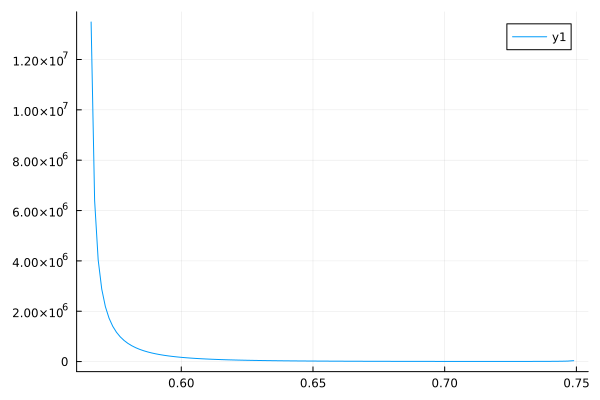

In [95]:
lambda0 = eigvals[1]
lambda1 = eigvals[3]

vals = LinRange(lambda0, lambda1, 100)

norm_res = [1/(svd(x*I-midP).S[end]) for x in vals]

plot(abs.(vals)[2:end-1], norm_res[2:end-1])

#E = BallArithmetic._compute_exclusion_circle_level_set_priori(
#            F.T, λ, 2^(-20); rel_pearl_size = 1/128, max_initial_newton = 100)

In [96]:
abs(lambda0)

0.7513009550106898

In [97]:
min_res_norm, i = findmin(norm_res)
@info vals[i], min_res_norm

exclusion_radius = abs(vals[i])

0.7172277249055798

In [98]:
bws = weak_strong(exclusion_radius; η = η_s, α = α_s, ρ = ρ_s)

1.8142845872464985e38

In [99]:
T = UpperTriangular(F.T)

1025×1025 UpperTriangular{ComplexF64, Matrix{ComplexF64}}:
 0.694112+0.28751im  4.11281e-14+2.14607e-14im  …   3.64712e-17-6.75994e-17im
          ⋅             0.694112-0.28751im          7.20129e-17+2.67202e-17im
          ⋅                      ⋅                  2.25695e-17-2.15959e-17im
          ⋅                      ⋅                 -2.12958e-17-2.28529e-17im
          ⋅                      ⋅                 -8.45989e-17-9.73316e-18im
          ⋅                      ⋅              …  -5.68231e-17-6.34258e-17im
          ⋅                      ⋅                 -6.13013e-17+8.77792e-17im
          ⋅                      ⋅                  1.05346e-16-1.91043e-17im
          ⋅                      ⋅                 -2.87151e-17+6.50994e-17im
          ⋅                      ⋅                 -5.57315e-17-4.19888e-17im
         ⋮                                      ⋱  
          ⋅                      ⋅                  1.06323e-16-2.70181e-16im
          ⋅                    

In [116]:
λ = eigvals[end]
@info λ
ϵ = 0.000001
target = 2 * ϵ
E1 = BallArithmetic._compute_enclosure_ode(F.T, λ, ϵ; target = target,  max_initial_newton = 100, max_steps = 1000)

Enclosure(1.0 + 0.0im, ComplexF64[1.000002 - 4.1633363421215476e-22im, 1.000001872658355 - 7.02246883194488e-7im, 1.0000015068493149 - 1.3150684932676934e-6im, 1.0000009491556046 - 1.7604271182038101e-6im, 1.000000270594858 - 1.9816100582028467e-6im, 0.9999995575761174 - 1.9504515139018686e-6im, 0.9999989008963616 - 1.6709192655528708e-6im, 0.999998384178271 - 1.1786094094574738e-6im, 0.9999980732215772 - 5.362134925302795e-7im, 0.9999980076240171 + 1.7446473255149437e-7im, 0.9999981957388919 + 8.629263316044335e-7im, 0.9999986136113439 + 1.4415014722026562e-6im, 0.9999992080288078 + 1.8365134442232338e-6im, 0.9999999032971861 + 1.9976607734506942e-6im, 1.0000006108798598 + 1.9044226938608751e-6im, 1.0000012406720873 + 1.5686722958471876e-6im, 1.0000017124750904 + 1.0331645874291686e-6im, 1.0000019662086987 + 3.66092001035302e-7im, 1.000001969562057 - 3.475993429406862e-7im], Ball{Float64, Float64}[Ball{Float64, Float64}(2.0000000002284498e-6, 5.00426560354213e-7), Ball{Float64, Float6

In [115]:
@info 1/(sqrt(N))*BallArithmetic.bound_resolvent(E1, errF, errT, norm_Z, norm_Z_inv))
certify_enclosure(E1, val_min, bws*sqrt(N), errF, errT, norm_Z, norm_Z_inv)

Base.Meta.ParseError: ParseError:
# Error @ /home/isaia/Dropbox/Lavoro/Collaborators/Blumenthal-Nisoli-Taylor-Crush/DraftPseudospectra/current/Julia_notebooks/20240515Blashke.ipynb:1:85
@info 1/(sqrt(N))*BallArithmetic.bound_resolvent(E1, errF, errT, norm_Z, norm_Z_inv))
#                                                                                   ╙ ── extra tokens after end of expression

In [102]:
λ = eigvals[2]
# @info λ
# ϵ = 0.00000001
# target = 2 * ϵ
E2 = BallArithmetic._compute_enclosure_ode(F.T, λ, ϵ; target = target,  max_initial_newton = 100, max_steps = 1000)

Enclosure(0.6941115750905701 - 0.2875104282026195im, ComplexF64[0.6943272198308676 - 0.28751043293134104im, 0.6943272172603534 - 0.287511182923708im, 0.694327212121138 - 0.2875119329029174im, 0.6943272043868076 - 0.2875126828598536im, 0.6943271940574388 - 0.2875134327855367im, 0.6943271811331773 - 0.28751418267098766im, 0.6943271656141586 - 0.2875149325072272im, 0.6943271475005723 - 0.287515682285277im, 0.6943271267926503 - 0.28751643199615995im, 0.694327103490617 - 0.2875171816308985im  …  0.6939027064631231 - 0.2874482721910247im, 0.6939029215292458 - 0.2874475536913456im, 0.6939031390803047 - 0.2874468359401612im, 0.6939033591137389 - 0.2874461189460791im, 0.6939035816268704 - 0.2874454027176712im, 0.6939038066170388 - 0.28744468726351463im, 0.6939040340815938 - 0.2874439725921901im, 0.6939042640177563 - 0.2874432587122372im, 0.6939044964228375 - 0.2874425456322247im, 0.6939047312939707 - 0.2874418333606636im], Ball{Float64, Float64}[Ball{Float64, Float64}(2.0000002468021717e-6, 5.0

In [103]:
@info 1/(sqrt(N)*BallArithmetic.bound_resolvent(E2, errF, errT, norm_Z, norm_Z_inv))
certify_enclosure(E2, val_min, bws*sqrt(N), errF, errT, norm_Z, norm_Z_inv)

true

In [104]:
# λ = eigvals[3]
# @info λ
# ϵ = 0.00000001
# target = 2 * ϵ
# E3 = BallArithmetic._compute_enclosure_ode(F.T, λ, ϵ; target = target,  max_initial_newton = 100, max_steps = 1000)

In [105]:
@info 1/(sqrt(N)*BallArithmetic.bound_resolvent(E3, errF, errT, norm_Z, norm_Z_inv))
certify_enclosure(E3, val_min, bws*sqrt(N), errF, errT, norm_Z, norm_Z_inv)

UndefVarError: UndefVarError: `E3` not defined

In [106]:
E_circ = BallArithmetic._compute_central_exclusion_circle(T, exclusion_radius; max_steps = 1000, rel_steps = 1024)

Enclosure(0 + 0im, ComplexF64[0.7172276185851791 + 0.0002761447589617429im, 0.7172275122644823 + 0.0005522897738953895im, 0.7172271933023109 + 0.000828435103476846im, 0.7172268743378379 + 0.001104581423388488im, 0.7172263427292778 + 0.0013807286285644365im, 0.7172258111141493 + 0.001656877558424437im, 0.7172250668501855 + 0.0019330279441602534im, 0.7172243225731237 + 0.0022091807889291198im, 0.7172233656403431 + 0.002485335660179101im, 0.7172224086856731 + 0.0027614937248058176im  …  0.6949899841115481 + 0.17721311297655817im, 0.6949634133540298 + 0.1773175000300743im, 0.6949367491373306 + 0.17742175781635883im, 0.6949101975721645 + 0.17752593908991987im, 0.6948835525932048 + 0.17762999128965481im, 0.6948570202951737 + 0.1777339672316776im, 0.6948303946284006 + 0.17783781429290596im, 0.6948038816716282 + 0.17794158535093849im, 0.6947772753908317 + 0.17804522772083525im, 0.6947507818487855 + 0.17814879434155806im], Ball{Float64, Float64}[Ball{Float64, Float64}(0.0013700804804694115, 0.0

In [107]:
BallArithmetic.bound_resolvent(E_circ, errF, errT, norm_Z, norm_Z_inv)

2309.4140877859018

In [108]:
# using Plots

In [109]:
# @recipe function f(::Type{BallArithmetic.Enclosure}, E::BallArithmetic.Enclosure)
#     val_sen = [sen(2*π*x) for x in 0:0.1:1]
#     val_cos = [sen(2*π*x) for x in 0:0.1:1]
    
#     out_x = []
#     out_y = []

#     for (i, z) in enumerate(E.points)
#         append!(out_x, z.+ E.radiuses[i]*val_cos)
#         append!(out_y, z.+ E.radiuses[i]*val_sen)
#     end

#     return out_x, out_y
# end

In [110]:
# λ = eigvals[4]
# @info λ
# ϵ = 0.00001
# target = 2 * ϵ
# E = BallArithmetic._compute_enclosure_ode(F.T, λ, ϵ; target = target,  max_initial_newton = 100, max_steps = 1000)

In [111]:
1.93*10.0^(36-47)*9/(0.5)

3.4739999999999996e-10

In [112]:
bigger_radius_square(ρ) = minimum(abs.(B.([ρ * exp(im * 2 * π * θ) for θ in 0:0.001:1]))) - ρ^2

bigger_radius_square (generic function with 1 method)

In [113]:
smaller_radius_square(ρ) = 1 / ρ^2 - maximum(abs.(B.([exp(im * 2 * π * θ) / ρ for θ in 0:0.001:1])))

smaller_radius_square (generic function with 1 method)

In [114]:
radius_square(ρ) = min(bigger_radius_square(ρ), smaller_radius_square(ρ))

radius_square (generic function with 1 method)